# Calibration Tutorial

## Step 2: Running the Uncalibrated Model

Just as in the first tutorial, we'll run the model in it's uncalibrated state. In this case, we'll have data from John Volk's study to compare our ouputs.

- The paper: https://www.sciencedirect.com/science/article/pii/S0168192323000011
- The data: https://www.sciencedirect.com/science/article/pii/S2352340923003931

In [13]:
import os
import sys
import json
import toml
import time
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

root = os.path.abspath('../../..')
sys.path.append(root)

from swim.config import ProjectConfig
from swim.input import SamplePlots
from model.etd import obs_field_cycle

from viz.swim_timeseries import plot_swim_timeseries

### 1. Configure and intialize the model.

We're going to setup and run the model in one go:

In [2]:
def run_fields(ini_path, project_ws, selected_feature, output_csv):
    start_time = time.time()

    config = ProjectConfig()
    config.read_config(ini_path, project_ws)

    fields = SamplePlots()
    fields.initialize_plot_data(config)
    fields.output = obs_field_cycle.field_day_loop(config, fields, debug_flag=True)

    end_time = time.time()
    print('\nExecution time: {:.2f} seconds\n'.format(end_time - start_time))

    out_df = fields.output[selected_feature].copy()

    in_df = fields.input_to_dataframe(selected_feature)

    df = pd.concat([out_df, in_df], axis=1, ignore_index=False)
    df.to_csv(output_csv)

In [5]:
project_ws = os.path.join(root, 'tutorials', '2_Fort_Peck')

data = os.path.join(project_ws, 'data')

config_file = os.path.join(data, 'tutorial_config.toml')
prepped_input = os.path.join(data, 'prepped_input.json')

selected_feature = 'US-FPe'
out_csv = os.path.join(project_ws, 'step_2_uncalibrated_model', f'combined_output_{selected_feature}.csv')

run_fields(config_file, project_ws, selected_feature=selected_feature, output_csv=out_csv)



Config: /home/dgketchum/PycharmProjects/swim-rs/tutorials/2_Fort_Peck/data/tutorial_config.toml
CALIBRATION OFF
FORECAST OFF

Execution time: 8.23 seconds



In [12]:
df = pd.read_csv(out_csv, index_col=0, parse_dates=True)
print(df.shape)
print(df.columns)

(13149, 79)
Index(['et_act', 'etref', 'kc_act', 'kc_bas', 'ks', 'ke', 'melt', 'rain',
       'depl_root', 'depl_ze', 'dperc', 'runoff', 'delta_soil_water', 'wbal',
       'ppt', 'snow_fall', 'taw', 'taw3', 'daw3', 'delta_daw3', 'swe', 'tavg',
       'tmax', 'irrigation', 'fc', 't', 'e', 'few', 'zr', 'p_rz', 'p_eft',
       'soil_water', 'niwr', 'irr_day', 'season', 'capture', 'doy', 'tmin_c',
       'tmax_c', 'srad_wm2', 'obs_swe', 'prcp_mm', 'nld_ppt_d', 'prcp_hr_00',
       'prcp_hr_01', 'prcp_hr_02', 'prcp_hr_03', 'prcp_hr_04', 'prcp_hr_05',
       'prcp_hr_06', 'prcp_hr_07', 'prcp_hr_08', 'prcp_hr_09', 'prcp_hr_10',
       'prcp_hr_11', 'prcp_hr_12', 'prcp_hr_13', 'prcp_hr_14', 'prcp_hr_15',
       'prcp_hr_16', 'prcp_hr_17', 'prcp_hr_18', 'prcp_hr_19', 'prcp_hr_20',
       'prcp_hr_21', 'prcp_hr_22', 'prcp_hr_23', 'etr_mm', 'eto_mm', 'etf_irr',
       'ndvi_irr', 'etf_irr_ct', 'ndvi_irr_ct', 'etr_mm_uncorr',
       'eto_mm_uncorr', 'etf_inv_irr', 'ndvi_inv_irr', 'etf_inv_irr_ct',


Timestamp('1987-01-01 00:00:00')

Let's plot with the same function from the first tutorial, which is also in `viz.swim_timeseries`.

total irrigation: 0.0
total et: 309.3
total precip: 312.0


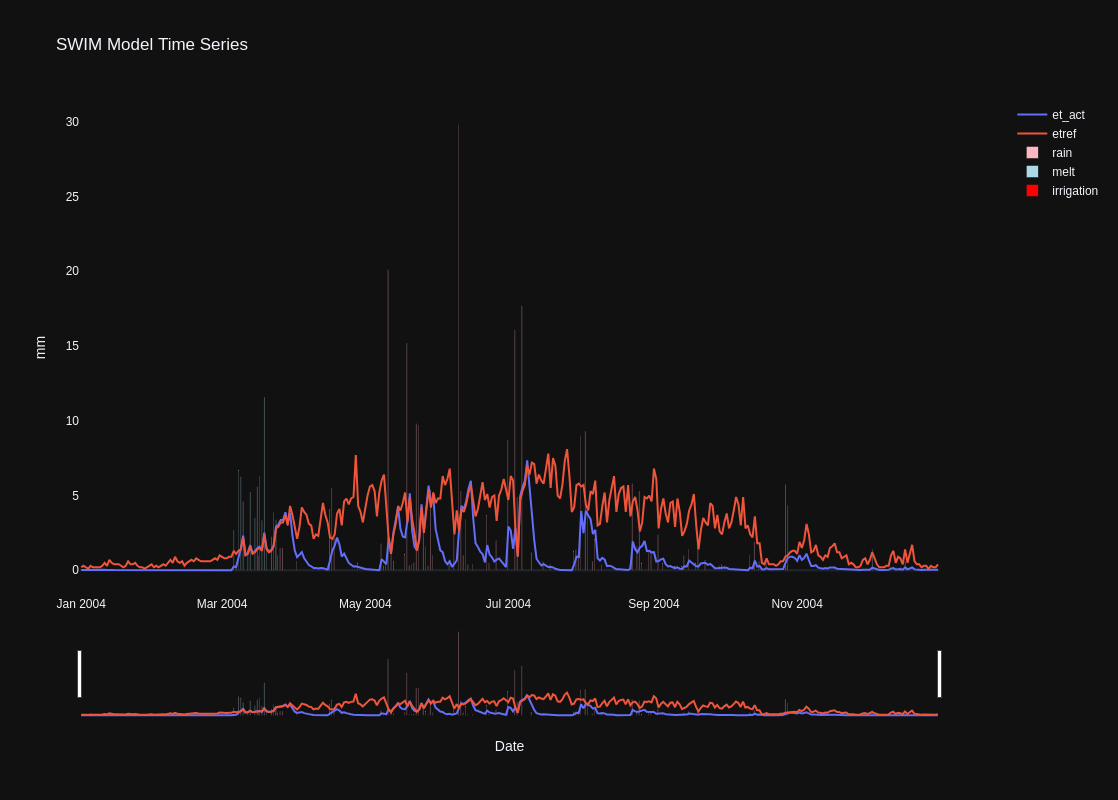

In [10]:
ydf = df.loc['2004-01-01': '2004-12-31']
print(f'total irrigation: {ydf.irrigation.sum():.1f}')
print(f'total et: {ydf.et_act.sum():.1f}')
print(f'total precip: {ydf.ppt.sum():.1f}')
plot_swim_timeseries(ydf, ['et_act', 'etref', 'rain', 'melt', 'irrigation'], start='2004-01-01', end='2004-12-31', png_file='et.png')

<img src='et.png'> 

This is going **SWIMmingly**. 

Now we have three estimates of the rate of ET as a ratio of reference ET: 

1. We have the capture-date SSEBop retrievals of ETf. Note that during the processing of the ETf data, we wrote an e.g., etf_inv_irr_ct.csv table that simply marked the image capture dates with a '1'. This data is included in our model input file.
2. We have SWIM's version of the dual crop coefficient model parameter 'Kc' (i.e., 'Kc_act'), which is the analog of ETf.
3. From the flux network, we have observations of the energy balance and water vapor fluxes, from which an independent estimate of ETf is made by Volk et al. This is 'ETof' in their daily flux data tables.

Let's compare our Kc with the ETf we extracted from SSEBop in terms of their agreement with the flux data from the Fort Peck station:

In [17]:
def compare_etf_estimates(combined_output_path, flux_data_path):
    flux_data = pd.read_csv(flux_data_path)
    flux_data = flux_data.set_index(pd.to_datetime(flux_data['date']))['EToF']

    combined_output = pd.read_csv(combined_output_path, index_col=0)
    combined_output.index = pd.to_datetime(combined_output.index)

    df = pd.DataFrame({'kc_act': combined_output['kc_act'],
                       'etf_inv_irr': combined_output['etf_inv_irr'],
                       'etf_inv_irr_ct': combined_output['etf_inv_irr_ct'],
                       'EToF': flux_data})

    # filter for days that have a SSEBop ETf retrieval and a flux observation
    df = df.dropna()
    df = df.loc[df['etf_inv_irr_ct'] == 1]

    # Calculate RMSE and R-squared
    rmse_kc_act = np.sqrt(mean_squared_error(df['EToF'], df['kc_act']))
    r2_kc_act = r2_score(df['EToF'], df['kc_act'])

    rmse_ssebop = np.sqrt(mean_squared_error(df['EToF'], df['etf_inv_irr']))
    r2_ssebop = r2_score(df['EToF'], df['etf_inv_irr'])

    print(f"SWIM Kc_act vs. Flux EToF: RMSE = {rmse_kc_act:.2f}, R-squared = {r2_kc_act:.2f}")
    print(f"SSEBop ETf vs. Flux EToF: RMSE = {rmse_ssebop:.2f}, R-squared = {r2_ssebop:.2f}")

    
flux_data = os.path.join(data, 'US-FPe_daily_data.csv')
compare_etf_estimates(out_csv, flux_data)
    

SWIM Kc_act vs. Flux EToF: RMSE = 0.26, R-squared = -0.63
SSEBop ETf vs. Flux EToF: RMSE = 0.25, R-squared = -0.48


Surprisingly, the model doesn't do much worse than SSEBop just using default parameters. Let's calibrate and see if we can improve on the model performance.